In [1]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU, BatchNormalization
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/"My Drive"/FMA_Music

/content/drive/My Drive/FMA_Music


In [4]:
!ls

Activation_Visualization.ipynb	 loaddata
baseline_model_mfcc_fma.ipynb	 load_fma_dataset.ipynb
checksums			 models
classification_cnn_2d_FMA.ipynb  not_found.pickle
classification_cnn_vgg16.ipynb	 Plot_Spectograms.ipynb
CNNonMusicData.ipynb		 predict
CNN_RNN_parallel_FMA.ipynb	 project_report.pdf
convert_to_npz.ipynb		 README.md
convert_to_npz.py		 songs
CRNN_model_FMA.ipynb		 test_arr.npz
csv				 test_classification_cnn_2d.ipynb
data				 train_arr.npz
Embedding_Clustering_CRNN.ipynb  valid_arr.npz
fma_small


### Load training and Validation arrays

In [5]:
dict_genres = {'Electronic':0,  'Folk':1,  'Pop' :2, 'Instrumental':3 }

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Folk', 2: 'Pop', 3: 'Instrumental'}


In [6]:
npzfile = np.load('loaddata/suf_train_arr.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(9597, 420, 128) (9597,)


In [7]:
npzfile = np.load('loaddata/suf_valid_arr.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(1200, 420, 128) (1200,)


In [0]:
y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)

### Parallel CNN - RNN Model

In [0]:
batch_size = 32
num_classes = 4
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [0]:
nb_filters1=16 
nb_filters2=32 
nb_filters3=64
nb_filters4=64
nb_filters5=64
ksize = (3,3)
pool_size_1= (2,2) 
pool_size_2 = (4,2)

lstm_count = 64
num_units = 120

BATCH_SIZE = 32
EPOCH_COUNT = 70
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
        ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_1')(layer)
    batch_1 = BatchNormalization()(conv_1)
    pool_1 = MaxPooling2D(pool_size_1)(batch_1)
    dropout_1=Dropout(0.25)(pool_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_2')(dropout_1)
    batch_2 = BatchNormalization()(conv_2)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)
    dropout_2=Dropout(0.25)(pool_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_3')(dropout_2)
    batch_3 = BatchNormalization()(conv_3)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    dropout_3=Dropout(0.25)(pool_3)
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_4')(dropout_3)
    batch_4 = BatchNormalization()(conv_4)
    pool_4 = MaxPooling2D(pool_size_1)(conv_4)
    dropout_4=Dropout(0.25)(pool_4)
    
    conv_5 = Conv2D(filters = nb_filters5, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_5')(dropout_4)
    batch_5 = BatchNormalization()(conv_5)
    pool_5 = MaxPooling2D(pool_size_1)(conv_5)
    dropout_5=Dropout(0.25)(pool_5)
    flatten1 = Flatten()(dropout_5)
    ### Recurrent Block
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_2, name = 'pool_lstm')(layer)
    
    # Embedding layer

    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
    
    # Bidirectional GRU
    lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat
    
    # Concat Output
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat')
    dropout_6=Dropout(0.25)(concat)
    ## Softmax Output
    output = Dense(num_classes, activation = 'softmax', name='preds')(dropout_6)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(lr=0.001)
    #opt = RMSprop(lr=0.0005)  # Optimizer
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [0]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_frequency = 128
    n_frames = 420
    #reshape and expand dims for conv2d
#     x_train = x_train.reshape(-1, n_frequency, n_frames)
    x_train = np.expand_dims(x_train, axis = -1)
    
#     x_val = x_val.reshape(-1, n_frequency, n_frames)
    x_val = np.expand_dims(x_val, axis = -1)
    
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/parallel/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
  
    #earlyStopping = EarlyStopping(monitor='val_acc', patience=70, verbose=1, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history


In [0]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [13]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

W0704 10:31:21.721053 140672330254208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 10:31:21.809030 140672330254208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 10:31:21.841804 140672330254208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 10:31:21.856973 140672330254208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0704 10:31:21.859134 1406723302

Building model...


W0704 10:31:24.755593 140672330254208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0704 10:31:24.831824 140672330254208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0704 10:31:24.841113 140672330254208 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0704 10:31:25.765992 140672330254208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: Th

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 420, 128, 1)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 418, 126, 16) 160         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 418, 126, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 209, 63, 16)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


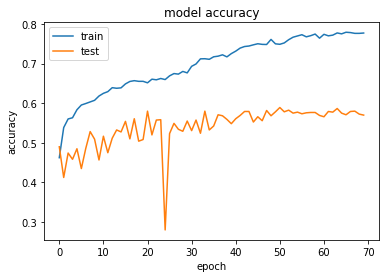

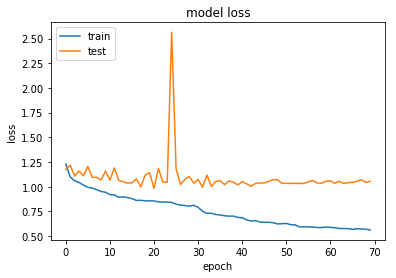

In [14]:
show_summary_stats(history)

In [15]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
X_valid = np.expand_dims(X_valid, axis = -1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))


(1200,) (1200,)
              precision    recall  f1-score   support

  Electronic       0.64      0.66      0.65       300
        Folk       0.71      0.59      0.64       300
         Pop       0.41      0.42      0.42       300
Instrumental       0.54      0.61      0.58       300

    accuracy                           0.57      1200
   macro avg       0.58      0.57      0.57      1200
weighted avg       0.58      0.57      0.57      1200



In [16]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.57


### Look at the Test Set

In [17]:
npzfile = np.load('loaddata/test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)
te_idx = np.random.permutation(len(X_test))
X_test = X_test[te_idx]
y_test = y_test[te_idx]

['arr_0', 'arr_1']
(1200, 420, 128) (1200,)


In [0]:
from keras.models import load_model

weights_path = 'models/parallel/weights.best.h5'
model = load_model(weights_path)

In [19]:
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 3 1.5


In [20]:
from sklearn.metrics import classification_report

y_true = y_test
X_test = np.expand_dims(X_test, axis = -1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(1200,) (1200,)
              precision    recall  f1-score   support

  Electronic       0.68      0.70      0.69       300
        Folk       0.45      0.32      0.38       300
         Pop       0.50      0.48      0.49       300
Instrumental       0.41      0.53      0.46       300

    accuracy                           0.51      1200
   macro avg       0.51      0.51      0.50      1200
weighted avg       0.51      0.51      0.50      1200



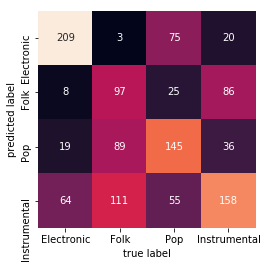

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

In [22]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

0.5075
